In [ ]:
!pip install einops

import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
      attn_list=[]

      for attn, ff in self.layers:
        attn_list.append(attn(x))
        x = attn(x) + x
        x = ff(x) + x

      return self.norm(x),attn_list

class ViT1(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x,attn_list = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x),attn_list


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.3 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 169001437/169001437 [00:13<00:00, 12478966.64it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device='cuda'
#from vit_pytorch import ViT
model = ViT1(
    image_size = 224,
    patch_size = 16,
    num_classes = 100,
    dim = 768,
    depth = 12,
    heads =12,
    mlp_dim = 3072,
    dropout = 0.1,
    emb_dropout = 0.1
).to(device)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
from tqdm import tqdm
device = 'cuda'
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(trainloader):
        data = data.to(device)
        label = label.to(device)

        output ,att= model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(trainloader)
        epoch_loss += loss / len(trainloader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in testloader:
            data = data.to(device)
            label = label.to(device)

            val_output,att = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(testloader)
            epoch_val_loss += val_loss / len(testloader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


100%|██████████| 12500/12500 [14:04<00:00, 14.80it/s]


Epoch : 1 - loss : 3.7588 - acc: 0.1321 - val_loss : 3.4237 - val_acc: 0.1860



  1%|          | 130/12500 [00:22<35:33,  5.80it/s]

In [4]:
!wget "https://media-proc-wowm.bastillepost.com/wp-content/uploads/hongkong/2019/08/190812_EN_%E9%99%B3%E6%9B%89%E8%8F%AF1.jpg"

--2023-09-12 11:18:44--  https://media-proc-wowm.bastillepost.com/wp-content/uploads/hongkong/2019/08/190812_EN_%E9%99%B3%E6%9B%89%E8%8F%AF1.jpg
Resolving media-proc-wowm.bastillepost.com (media-proc-wowm.bastillepost.com)... 104.22.53.207, 172.67.10.11, 104.22.52.207, ...
Connecting to media-proc-wowm.bastillepost.com (media-proc-wowm.bastillepost.com)|104.22.53.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/png]
Saving to: ‘190812_EN_陳曉華1.jpg’

190812_EN_陳曉華1.j     [    <=>             ] 322.98K   438KB/s    in 0.7s    

2023-09-12 11:18:46 (438 KB/s) - ‘190812_EN_陳曉華1.jpg’ saved [330735]



In [ ]:
!wget https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
import os,json
idx2label, cls2label, cls2idx = [], {}, {}
with open(os.path.abspath('imagenet_class_index.json'), 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

--2023-09-12 08:52:30--  https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [text/plain]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      

2023-09-12 08:52:30 (170 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]



(224, 224, 3)


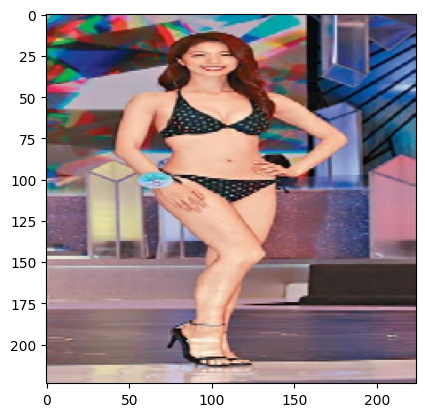

In [ ]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('190812_EN_陳曉華1.jpg')
img = cv2.resize(img,(224,224))
print(img.shape)
plt.imshow(img[...,::-1])
plt.show()

In [ ]:
input_img = torch.from_numpy(img)
input_img = input_img.unsqueeze(0).permute(0,3,1,2)
preds=model(input_img/255)
pred_softmax = F.softmax(preds, dim=1)
top_n = pred_softmax.topk(5)
top_n


torch.return_types.topk(
values=tensor([[0.7603, 0.0391, 0.0129, 0.0124, 0.0024]], grad_fn=<TopkBackward0>),
indices=tensor([[445, 638, 639, 459, 842]]))

In [ ]:
input_img = torch.from_numpy(img)
input_img = input_img.unsqueeze(0).permute(0,3,1,2)
print(input_img.shape)
preds, attn_map = v(input_img/255)
pred_softmax = F.softmax(preds, dim=1)
top_n = pred_softmax.topk(5)
top_n

torch.Size([1, 3, 224, 224])


torch.return_types.topk(
values=tensor([[0.0057, 0.0044, 0.0037, 0.0036, 0.0036]], grad_fn=<TopkBackward0>),
indices=tensor([[939, 115, 407, 277, 618]]))

In [ ]:
idx2label[445]

'bikini'

In [ ]:
attn_map.shape
mean_map = attn_map.mean(1)[0,0,1:].reshape(14,14)
#attn_map_per_head = attn_map[0,3,0,1:].reshape(14,14)
plt.imshow(mean_map.detach().numpy())
#plt.show()

In [ ]:
attn_map.shape

torch.Size([1, 12, 197, 197])

In [1]:
!git clone https://github.com/luo3300612/Visualizer.git

Cloning into 'Visualizer'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (206/206), done.
remote: Total 240 (delta 37), reused 225 (delta 29), pack-reused 0
Receiving objects: 100% (240/240), 3.83 MiB | 16.62 MiB/s, done.
Resolving deltas: 100% (37/37), done.


In [2]:
!pip install bytecode

In [3]:
%cd Visualizer

/content/Visualizer


In [5]:
from visualizer import get_local
get_local.activate()
import torch
import torchvision.transforms as T
from timm.models.vision_transformer import vit_small_patch16_224
import json
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def grid_show(to_shows, cols):
    rows = (len(to_shows)-1) // cols + 1
    it = iter(to_shows)
    fig, axs = plt.subplots(rows, cols, figsize=(rows*8.5, cols*2))
    for i in range(rows):
        for j in range(cols):
            try:
                image, title = next(it)
            except StopIteration:
                image = np.zeros_like(to_shows[0][0])
                title = 'pad'
            axs[i, j].imshow(image)
            axs[i, j].set_title(title)
            axs[i, j].set_yticks([])
            axs[i, j].set_xticks([])
    plt.show()

def visualize_head(att_map):
    ax = plt.gca()
    # Plot the heatmap
    im = ax.imshow(att_map)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    plt.show()

def visualize_heads(att_map, cols):
    to_shows = []
    att_map = att_map.squeeze()
    for i in range(att_map.shape[0]):
        to_shows.append((att_map[i], f'Head {i}'))
    average_att_map = att_map.mean(axis=0)
    to_shows.append((average_att_map, 'Head Average'))
    grid_show(to_shows, cols=cols)

def gray2rgb(image):
    return np.repeat(image[...,np.newaxis],3,2)

def cls_padding(image, mask, cls_weight, grid_size):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    image = np.array(image)

    H, W = image.shape[:2]
    delta_H = int(H/grid_size[0])
    delta_W = int(W/grid_size[1])

    padding_w = delta_W
    padding_h = H
    padding = np.ones_like(image) * 255
    padding = padding[:padding_h, :padding_w]

    padded_image = np.hstack((padding,image))
    padded_image = Image.fromarray(padded_image)
    draw = ImageDraw.Draw(padded_image)
    draw.text((int(delta_W/4),int(delta_H/4)),'CLS', fill=(0,0,0)) # PIL.Image.size = (W,H) not (H,W)

    mask = mask / max(np.max(mask),cls_weight)
    cls_weight = cls_weight / max(np.max(mask),cls_weight)

    if len(padding.shape) == 3:
        padding = padding[:,:,0]
        padding[:,:] = np.min(mask)
    mask_to_pad = np.ones((1,1)) * cls_weight
    mask_to_pad = Image.fromarray(mask_to_pad)
    mask_to_pad = mask_to_pad.resize((delta_W, delta_H))
    mask_to_pad = np.array(mask_to_pad)

    padding[:delta_H,  :delta_W] = mask_to_pad
    padded_mask = np.hstack((padding, mask))
    padded_mask = padded_mask

    meta_mask = np.zeros((padded_mask.shape[0], padded_mask.shape[1],4))
    meta_mask[delta_H:,0: delta_W, :] = 1

    return padded_image, padded_mask, meta_mask


def visualize_grid_to_grid_with_cls(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    attention_map = att_map[grid_index]
    cls_weight = attention_map[0]

    mask = attention_map[1:].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))

    padded_image ,padded_mask, meta_mask = cls_padding(image, mask, cls_weight, grid_size)

    if grid_index != 0: # adjust grid_index since we pad our image
        grid_index = grid_index + (grid_index-1) // grid_size[1]

    grid_image = highlight_grid(padded_image, [grid_index], (grid_size[0], grid_size[1]+1))

    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()

    ax[0].imshow(grid_image)
    ax[0].axis('off')

    ax[1].imshow(grid_image)
    ax[1].imshow(padded_mask, alpha=alpha, cmap='rainbow')
    ax[1].imshow(meta_mask)
    ax[1].axis('off')


def visualize_grid_to_grid(att_map, grid_index, image, grid_size=14, alpha=0.6):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    H,W = att_map.shape
    with_cls_token = False

    grid_image = highlight_grid(image, [grid_index], grid_size)

    mask = att_map[grid_index].reshape(grid_size[0], grid_size[1])
    mask = Image.fromarray(mask).resize((image.size))

    fig, ax = plt.subplots(1, 2, figsize=(10,7))
    fig.tight_layout()

    ax[0].imshow(grid_image)
    ax[0].axis('off')

    ax[1].imshow(grid_image)
    ax[1].imshow(mask/np.max(mask), alpha=alpha, cmap='rainbow')
    ax[1].axis('off')
    plt.show()

def highlight_grid(image, grid_indexes, grid_size=14):
    if not isinstance(grid_size, tuple):
        grid_size = (grid_size, grid_size)

    W, H = image.size
    h = H / grid_size[0]
    w = W / grid_size[1]
    image = image.copy()
    for grid_index in grid_indexes:
        x, y = np.unravel_index(grid_index, (grid_size[0], grid_size[1]))
        a= ImageDraw.ImageDraw(image)
        a.rectangle([(y*w,x*h),(y*w+w,x*h+h)],fill =None,outline ='red',width =2)
    return image

In [7]:
image = Image.open('190812_EN_陳曉華1.jpg')

In [8]:
imagenet_cls = json.load(open('./imagenet_cls.json'))
normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transforms = T.Compose([
            T.Resize(256),
            T.CenterCrop(224),
            T.ToTensor(),
            normalize,
        ])
input_tensor = transforms(image).unsqueeze(0)
input_tensor.shape

torch.Size([1, 3, 224, 224])

In [ ]:
get_local.clear()
with torch.no_grad():
    vit = vit_small_patch16_224(pretrained=True)
    out = vit(input_tensor)

print('Top1 prediction:')
print(imagenet_cls[str(out.argmax().item())])

In [10]:
cache = get_local.cache
print(list(cache.keys()))

['Attention.forward']


# 12 **layers**

In [11]:
attention_maps = cache['Attention.forward']
len(attention_maps)

12

# 6 **heads**

In [12]:
attention_maps[0].shape

(1, 6, 197, 197)

# **show attention map**

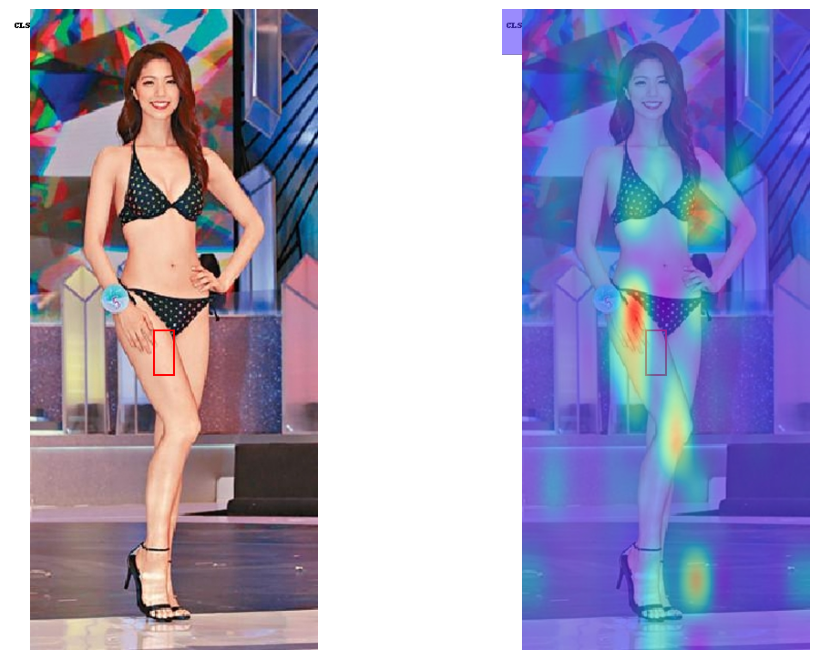

In [13]:
visualize_grid_to_grid_with_cls(attention_maps[4][0,4,:,:], 105, image)

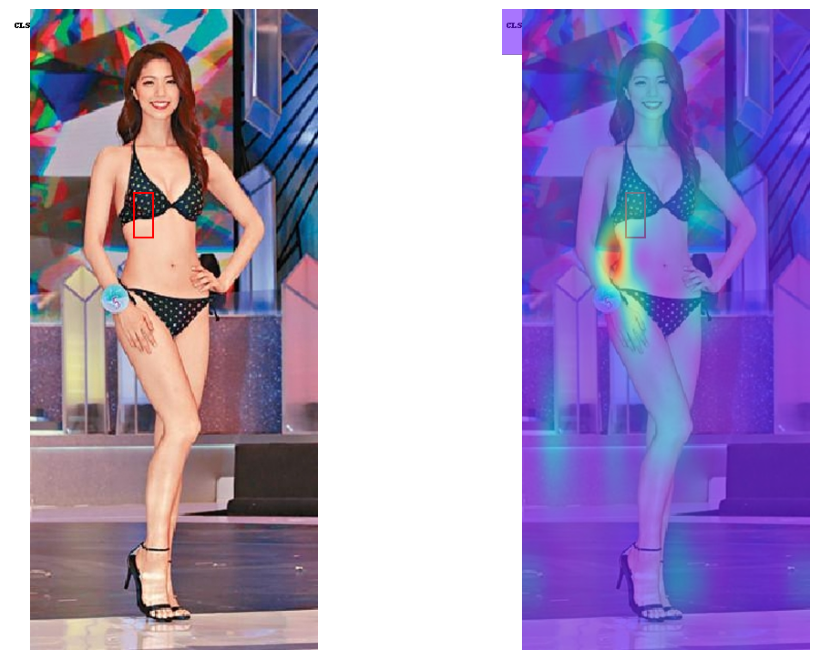

In [18]:
visualize_grid_to_grid_with_cls(attention_maps[4][0,4,:,:], 62, image)

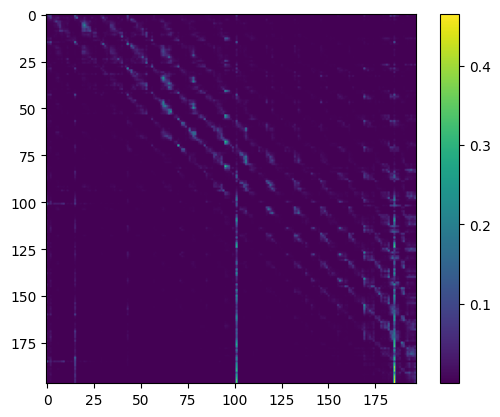

In [ ]:
visualize_head(attention_maps[7][0,1])

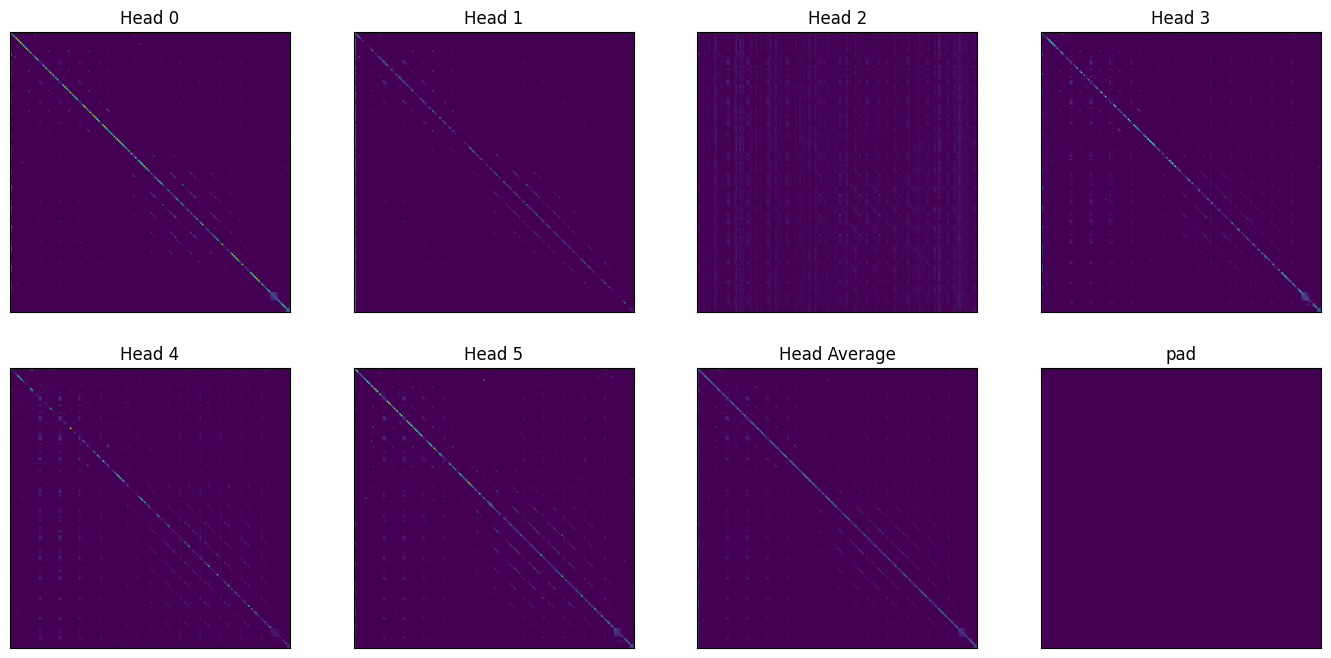

In [ ]:
visualize_heads(attention_maps[0], cols=4)


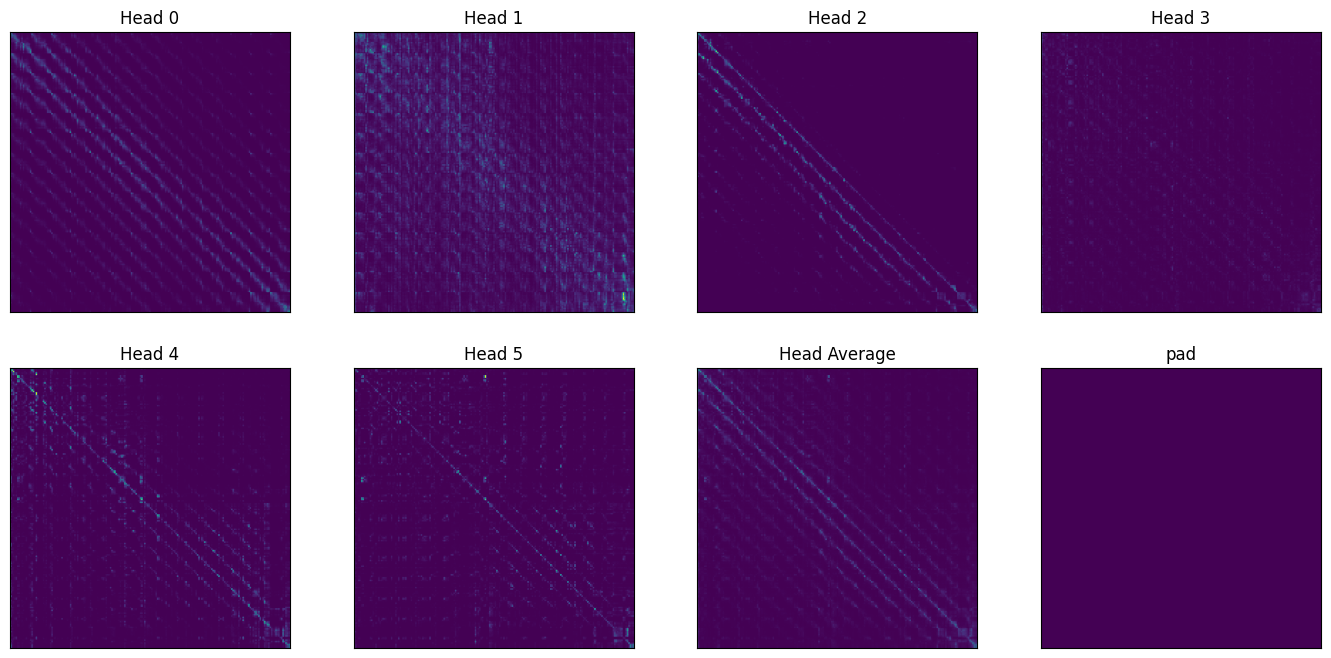

In [ ]:
visualize_heads(attention_maps[5], cols=4)

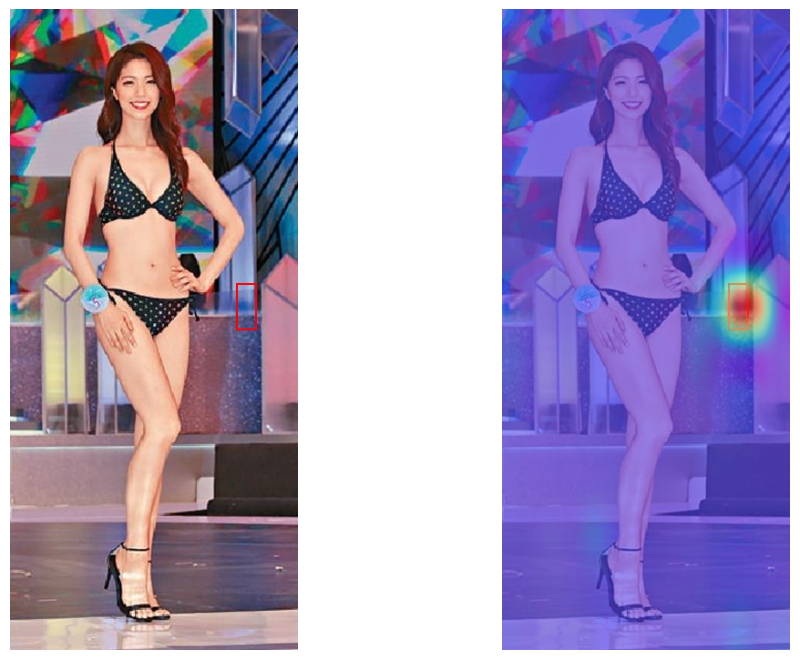

In [ ]:
visualize_grid_to_grid(attention_maps[3][0,0,1:,1:], 90, image)

In [19]:
from timm.models.swin_transformer import swin_base_patch4_window7_224

In [20]:
get_local.clear()
with torch.no_grad():
    swin = swin_base_patch4_window7_224(pretrained=True)
    out = swin(input_tensor)

print('Top1 prediction:')
print(imagenet_cls[str(out.argmax().item())])

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window7_224_22kto1k.pth


Top1 prediction:
['bikini', 'two-piece']


In [22]:
cache = get_local.cache
print(list(cache.keys()))

['Attention.forward']


In [23]:
attention_maps = cache['Attention.forward']
len(attention_maps)

0

In [24]:
attention_maps = cache['Attention.forward']
len(attention_maps)

0